# THIS SCRIPT ANALYZE THE SPATIOTEMPORAL TRENDS OF STANDARD PRECIPITATION INDEX (SPI-01) OVER THE UNITED STATES (1991 TO 2024)

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature


--- Processing dataset from: /glade/u/home/npinkrah/Kamal/nclimgrid-spei-pearson-01.nc ---
Generating annual timeseries for CONUS_SPEI 1991–2024...
Saved annual timeseries plot with trend: CONUS_SPEI_US_Annual_Timeseries_Trend_1991-2024.png


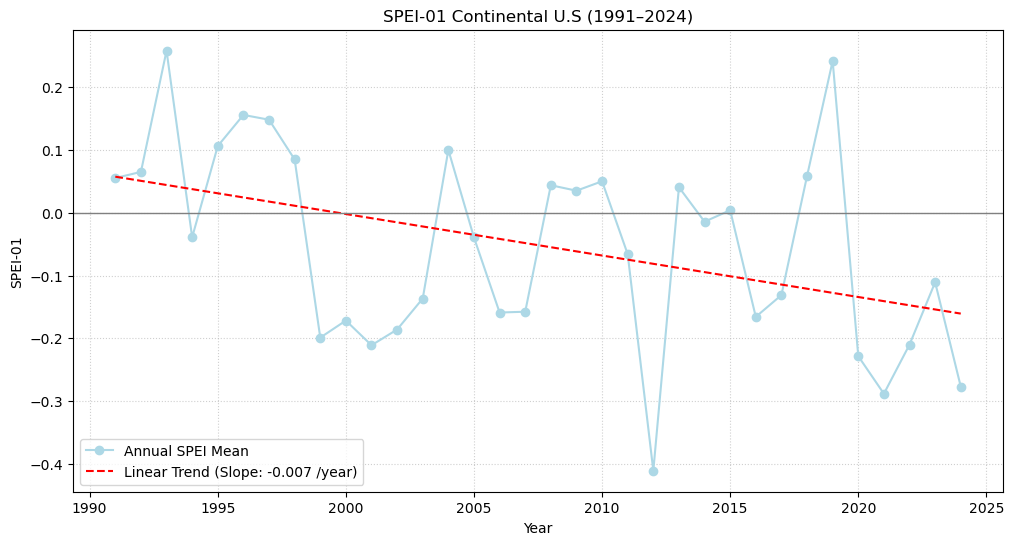

Calculating spatial trend for Continental U.S. (CONUS_SPEI) 1991–2024...
Saved U.S. spatial trend map: CONUS_SPEI_US_Spatial_Trend_1991-2024.png


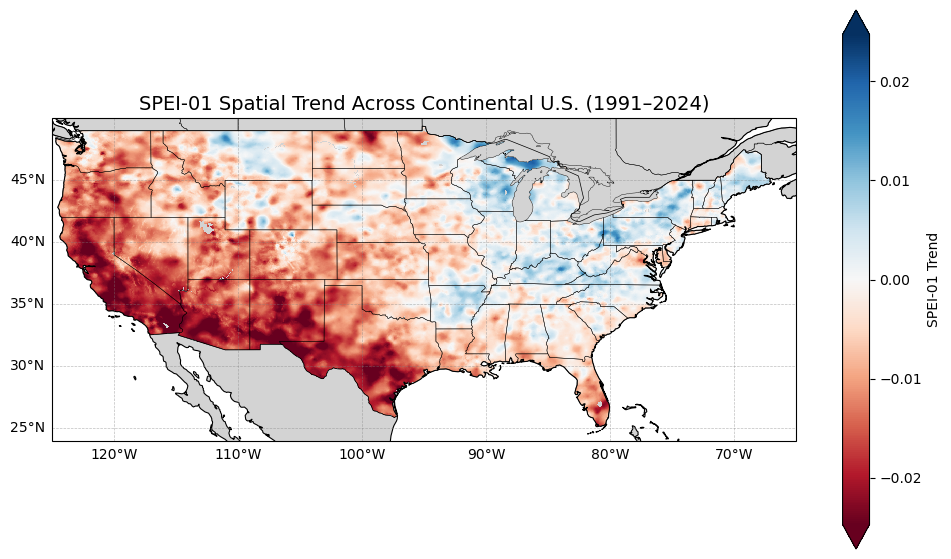

Calculating long-term spatial mean for Continental U.S. (CONUS_SPEI) 1991–2024...
Saved U.S. long-term mean spatial plot: CONUS_SPEI_US_LongTerm_Spatial_Mean_1991-2024.png


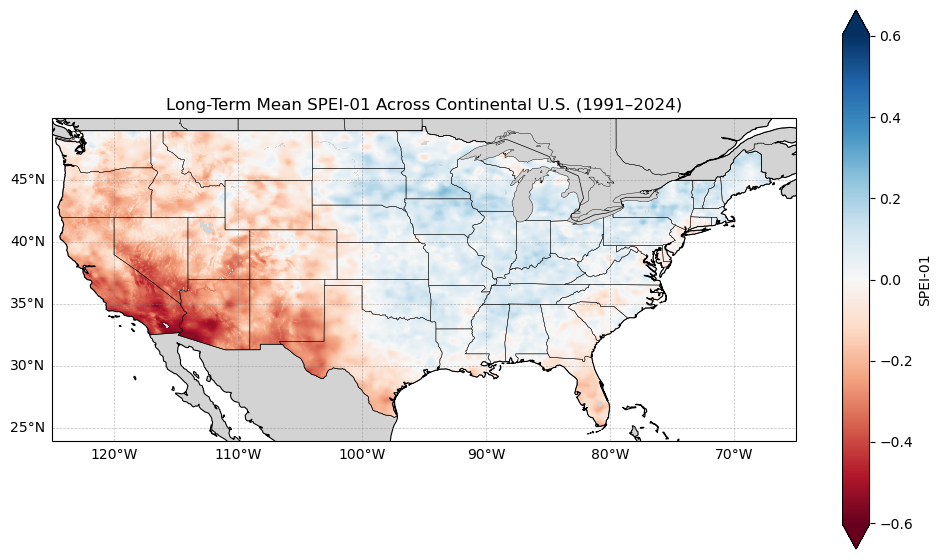


COMPLETE (1991–2024).


In [12]:
FILE_PATH = '/glade/u/home/npinkrah/Kamal/nclimgrid-spei-pearson-01.nc'
DATA_VAR_NAME = 'spei_01'

US_LON_MIN, US_LON_MAX = -125.0, -65.0
US_LAT_MIN, US_LAT_MAX = 24.0, 50.0

# start and end date
REQ_START_YEAR = 1991
REQ_END_YEAR   = 2024

def _subset_years(da, start_year, end_year):
    da_sub = da.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
    act_start = int(da_sub['time.year'].min())
    act_end   = int(da_sub['time.year'].max())
    return da_sub, act_start, act_end

def calculate_and_plot_annual_timeseries(da, title_prefix, start_year, end_year):
    print(f"Generating annual timeseries for {title_prefix} {start_year}–{end_year}...")
    # annual mean
    annual_mean_spei = da.groupby('time.year').mean('time').mean(['lat','lon'])
    x_years = annual_mean_spei['year'].values
    y_data  = annual_mean_spei.values

    m = np.isfinite(y_data)
    slope, intercept = 0.0, np.nanmean(y_data)
    if m.sum() >= 2:
        slope, intercept, *_ = linregress(x_years[m], y_data[m])

    trend_line = slope * x_years + intercept

    plt.figure(figsize=(12,6))
    plt.plot(x_years, y_data, marker='o', linestyle='-', color='lightblue', label='Annual SPEI Mean')
    plt.plot(x_years, trend_line, color='red', linestyle='--',
             label=f'Linear Trend (Slope: {slope:.3f} /year)')
    plt.axhline(0, color='gray', linestyle='-', linewidth=1)
    plt.title(f'SPEI-01 Continental U.S ({start_year}–{end_year})')
    plt.xlabel('Year'); plt.ylabel('SPEI-01'); plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend(loc='best')

    filename = f'{title_prefix}_US_Annual_Timeseries_Trend_{start_year}-{end_year}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved annual timeseries plot with trend: {filename}")
    plt.show()

def linregress_slope(y, x):
    m = np.isfinite(y)
    if m.sum() < 2:
        return np.nan
    return linregress(x[m], y[m]).slope

def calculate_and_plot_spatial_trend(da, title_prefix, start_year, end_year):
    print(f"Calculating spatial trend for Continental U.S. ({title_prefix}) {start_year}–{end_year}...")
    da_annual = da.groupby('time.year').mean('time')  # [year, lat, lon]
    years = da_annual['year'].values

    trend_slope = xr.apply_ufunc(
        linregress_slope, da_annual, years,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[[]],
        vectorize=True, dask='parallelized', output_dtypes=[float]
    )
    trend_slope.name = 'trend_slope'

    data_crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(1,1,1, projection=data_crs)
    ax.set_extent([US_LON_MIN, US_LON_MAX, US_LAT_MIN, US_LAT_MAX], crs=data_crs)

    valid = trend_slope.values[np.isfinite(trend_slope.values)]
    vmax = np.nanpercentile(np.abs(valid), 98) if valid.size else 1.0

    trend_slope.plot.pcolormesh(
        ax=ax, transform=data_crs, cmap='RdBu', center=0,
        vmin=-vmax, vmax=vmax, extend='both',
        cbar_kwargs={'label': 'SPEI-01 Trend'},
        add_labels=False
    )

    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.3, zorder=3)

    gl = ax.gridlines(crs=data_crs, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = False

    plt.title(f'SPEI-01 Spatial Trend Across Continental U.S. ({start_year}–{end_year})', fontsize=14)

    filename = f'{title_prefix}_US_Spatial_Trend_{start_year}-{end_year}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved U.S. spatial trend map: {filename}")
    plt.show()

def calculate_and_plot_spatial_mean(da, title_prefix, start_year, end_year):
    print(f"Calculating long-term spatial mean for Continental U.S. ({title_prefix}) {start_year}–{end_year}...")

    da_annual = da.groupby('time.year').mean('time')
    long_term_mean = da_annual.mean('year')

    data_crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(1,1,1, projection=data_crs)
    ax.set_extent([US_LON_MIN, US_LON_MAX, US_LAT_MIN, US_LAT_MAX], crs=data_crs)

    long_term_mean.plot.pcolormesh(
        ax=ax, transform=data_crs, cmap='RdBu', center=0, extend='both',
        cbar_kwargs={'label': f'SPEI-01'},
        add_labels=False
    )

    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, zorder=2)
    ax.add_feature(cfeature.STATES, linestyle='-', edgecolor='black', linewidth=0.3, zorder=3)

    gl = ax.gridlines(crs=data_crs, draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False; gl.right_labels = False

    plt.title(f'Long-Term Mean SPEI-01 Across Continental U.S. ({start_year}–{end_year})')

    filename = f'{title_prefix}_US_LongTerm_Spatial_Mean_{start_year}-{end_year}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Saved U.S. long-term mean spatial plot: {filename}")
    plt.show()

def process_file(filepath, title_prefix):
    print(f"\n--- Processing dataset from: {filepath} ---")
    ds = xr.open_dataset(filepath)
    da_full = ds[DATA_VAR_NAME]

    da, act_start, act_end = _subset_years(da_full, REQ_START_YEAR, REQ_END_YEAR)
    if (act_start != REQ_START_YEAR) or (act_end != REQ_END_YEAR):
        print(f"NOTE: Requested {REQ_START_YEAR}–{REQ_END_YEAR}, data available {act_start}–{act_end} after subsetting.")

    calculate_and_plot_annual_timeseries(da, title_prefix, act_start, act_end)
    calculate_and_plot_spatial_trend(da, title_prefix, act_start, act_end)
    calculate_and_plot_spatial_mean(da, title_prefix, act_start, act_end)

process_file(FILE_PATH, 'CONUS_SPEI')

print("\nCOMPLETE (1991–2024).")
